In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
import os

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
#sb.set_theme(style='whitegrid', palette='pastel')
sb.set_context("notebook", rc={"lines.linewidth": 0.6})
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [3]:
def get_msc(x, smooth=True):
    msc = x.groupby('time.dayofyear').mean()
    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1 - 366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367 + 366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_stack = msc_stack.rolling(dayofyear=31, min_periods=4, center=True).median()
    msc_smooth = msc_stack.rolling(dayofyear=41, min_periods=21, center=True).mean().sel(dayofyear=slice(1, 366))

    if smooth:
        return msc_smooth
    else:
        return msc

def add_timescales(x):
    for var in x.data_vars:
        x[var + '_msc'] = get_msc(x[var])
        x[var + '_iav'] = x[var].groupby('time.dayofyear') - x[var + '_msc']
    return x

def drop_first_year(x: xr.Dataset):
    x = x.sel(
        time=slice(
            str(x.time.dt.year[0].item() + 1),
            None
        )
    )
    return x

def compute_metrics(x, dim=None):
    res = xr.Dataset()
    for metric in ['nse', 'rmse']:
        for ext in ['', '_msc', '_iav']:
            obs = x['GPP' + ext]
            mod = x['GPP_hat' + ext]

            if dim == 'time':
                if ext == '_msc':
                    obs_dim = mod_dim = 'dayofyear'
                else:
                    obs_dim = mod_dim = 'time'
            elif dim is None:
                obs_dim = set(obs.dims) - {'model', 'quantile'}
                mod_dim = set(mod.dims) - {'model', 'quantile'}

            if metric == 'nse':
                met = 1 - (
                    ((obs - mod) ** 2).sum(mod_dim) / ((obs - obs.mean(obs_dim)) ** 2).sum(obs_dim)
                )
                met = 1 / (2 - met)
            elif metric == 'rmse':
                met = ((obs - mod) ** 2).mean(mod_dim) ** 0.5

            res[metric + ext] = met

    return res

In [4]:
models = [os.path.basename(d) for d in glob('../logs/*')]
models

['simplemlp',
 'gt_model',
 'linear',
 'attn',
 'resnet',
 'multimodel',
 'conv1d',
 'attn_nores',
 'lstm']

In [5]:
ds_space = xr.open_dataset('../logs/linear/extrap/space/predictions.nc').drop('GPP_hat')
ds_time = xr.open_dataset('../logs/linear/extrap/time/predictions.nc').drop('GPP_hat')
ds_val = xr.open_dataset('../logs/linear/xval/final/predictions.nc').drop('GPP_hat')

for data, dirname in zip([ds_space, ds_time, ds_val], ['space', 'time', 'xval']):
    dt = []
    for model in models:
        if dirname == 'xval':
            dt.append(xr.open_dataset(f'../logs/{model}/xval/final/predictions.nc')['GPP_hat'])
        else:
            dt.append(xr.open_dataset(f'../logs/{model}/extrap/{dirname}/predictions.nc')['GPP_hat'])

    data['GPP_hat'] = xr.concat(dt, dim='model')

ds_space = drop_first_year(ds_space).load()
ds_time = drop_first_year(ds_time).load()
ds_val = drop_first_year(ds_val).load()

ds_space = add_timescales(ds_space)
ds_time = add_timescales(ds_time)
ds_val = add_timescales(ds_val)

ds_space['model'] = models
ds_time['model'] = models
ds_val['model'] = models

met_space_global = compute_metrics(ds_space)
met_time_global = compute_metrics(ds_time)
met_val_global = compute_metrics(ds_val)

met_space = compute_metrics(ds_space, dim='time')
met_time = compute_metrics(ds_time, dim='time')
met_val = compute_metrics(ds_val, dim='time')


FileNotFoundError: [Errno 2] No such file or directory: b'/Net/Groups/BGI/scratch/relghawi/hack-attrib/hackathon-attribution/hackathon/logs/gt_model/extrap/space/predictions.nc'

In [ ]:
def plot_ts(pred, obs, co2, line_scale=1.0, locs=range(10), axes_only=False, axes=None, add_legend=False):
    if axes is None:
        fig, axes = plt.subplots(len(locs), 2, figsize=(20, len(locs) * 2), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.13}, sharex='col', sharey='row', squeeze=False)

    if axes_only:
        return fig, axes

    for l, loc in enumerate(locs):
        pred_ = pred.isel(location=loc)
        obs_ = obs.isel(location=loc)
        co2_ = co2.isel(location=loc)
        for s in range(2):
            if s == 0:
                line_scale_ = line_scale
            if s == 1:
                pred_ = pred_.sel(time=str(pred_.time.dt.year[-1].item()))
                obs_ = obs_.sel(time=str(obs_.time.dt.year[-1].item()))
                line_scale_ = line_scale * 2.0
            ax = axes[l, s]

            ax.plot(
                pred_.time,
                obs_,
                color='k',
                lw=0.5 * line_scale_,
                alpha=0.7,
                label='Observed GPP' if s == 0 else '__nolegend__')
            if s == 0:
                m = obs_.rolling(time=365 * 2, center=True).mean()
                ax.plot(
                    m.time,
                    m,
                    color='k',
                    lw=1.8 * line_scale_,
                    alpha=1.0,
                    zorder=9999,
                    label='Observed GPP trend' if s == 0 else '__nolegend__')
            ax.fill_between(
                x=pred_.time,
                y1=pred_.isel(quantile=0), 
                y2=pred_.isel(quantile=2),
                edgecolor='none',
                facecolor='tab:orange',
                alpha=0.4,
                label='Ensemble GPP 0.1-0.9 quantile' if s == 0 else '__nolegend__')
            ax.plot(
                pred_.time,
                pred_.isel(quantile=1),
                color='tab:orange',
                lw=0.5 * line_scale_,
                alpha=0.9,
                label='Ensemble GPP median' if s == 0 else '__nolegend__')

            if s == 0:
                m = pred_.isel(quantile=1).rolling(time=365 * 2, center=True).mean()
                ax.plot(
                    m.time,
                    m,
                    color='tab:red',
                    lw=1.5 * line_scale_,
                    alpha=1.0,
                    zorder=9999,
                    label='Ensemble GPP median trend' if s == 0 else '__nolegend__')
                ax2=ax.twinx()
                ax2.plot(
                    co2_.time,
                    co2_,
                    color='tab:blue',
                    lw=1.5 * line_scale_,
                    alpha=0.7,
                    zorder=9999,
                    label='Atmospheric CO2 forcing')
                ax2.set_ylabel('CO2 [ppm]')
                ax.set_ylabel('GPP')

                if add_legend:
                    ax2.legend(loc=1)
                    ax.legend(ncol=3)


In [ ]:
def plot_multimodel_ts(ds):
    fig, axes = plot_ts(pred=None, obs=None, co2=None, locs=range(len(models)), axes_only=True)

    for i, model in enumerate(models):
        plot_ts(pred=ds.GPP_hat.sel(model=model), obs=ds.GPP, co2=ds.co2, locs=range(1), axes=axes[i:i+1, :], add_legend=i==0)
        axes[i, 0].set_title(model)

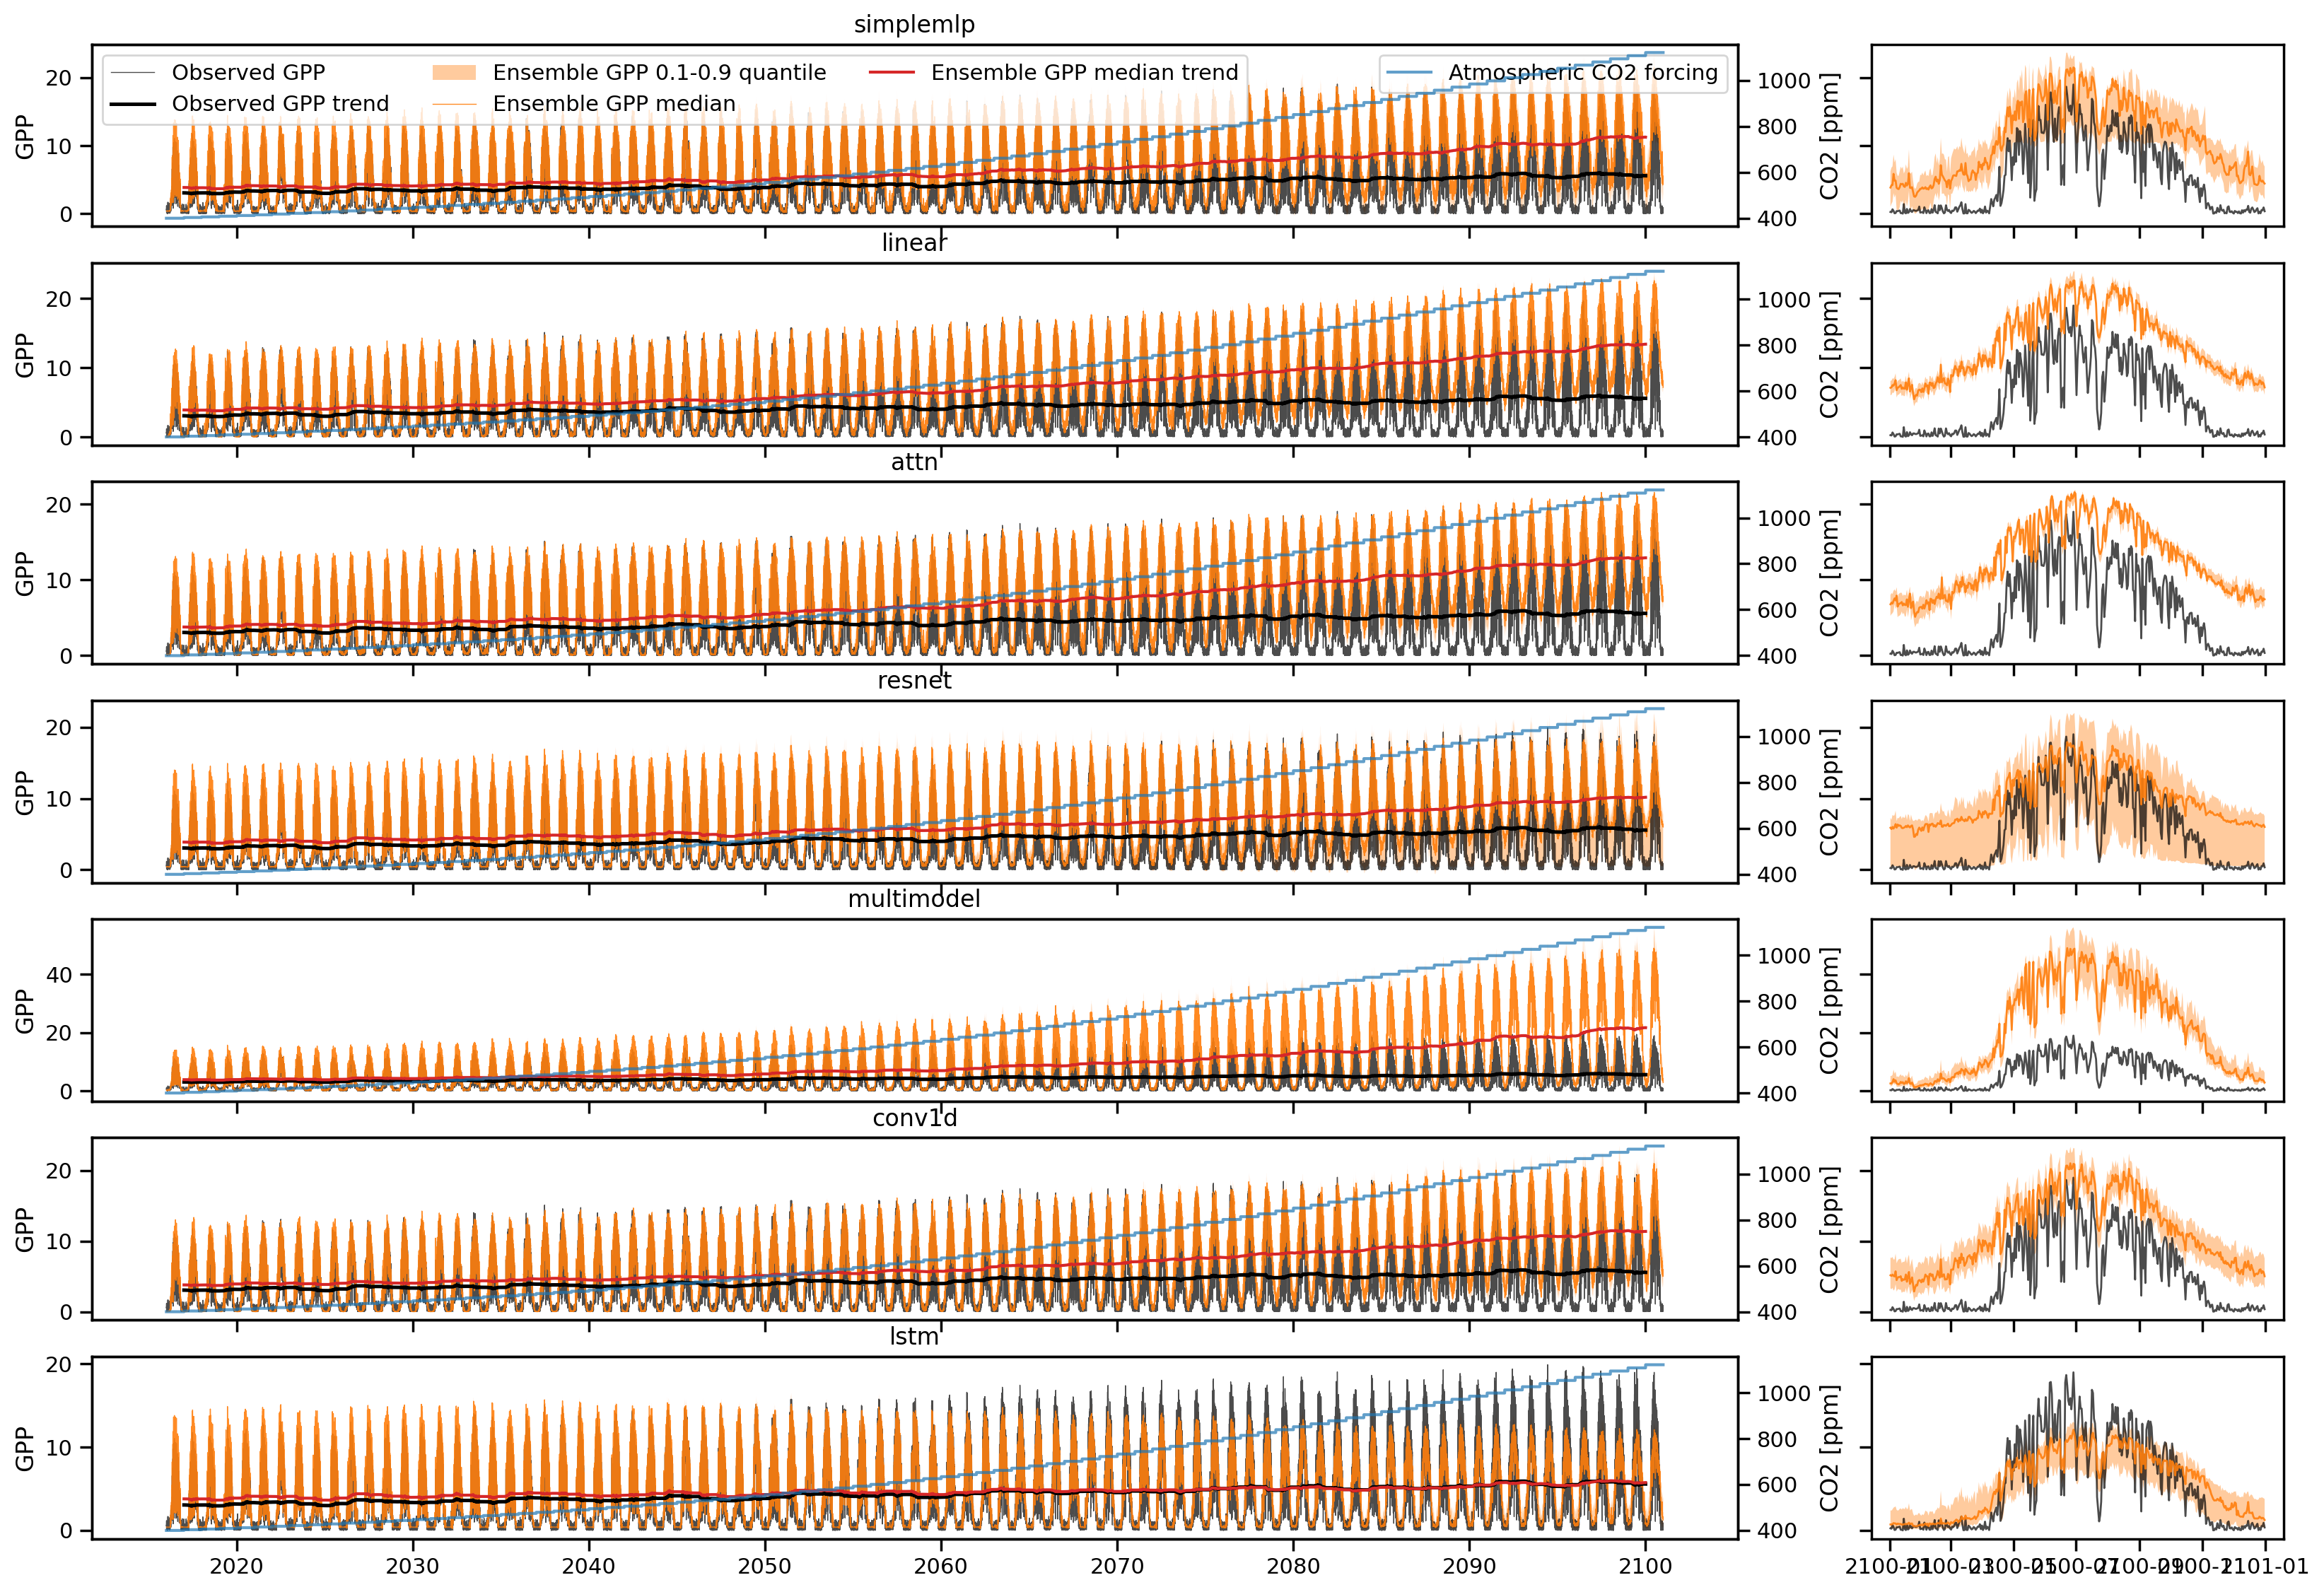

In [ ]:
plot_multimodel_ts(ds_time)

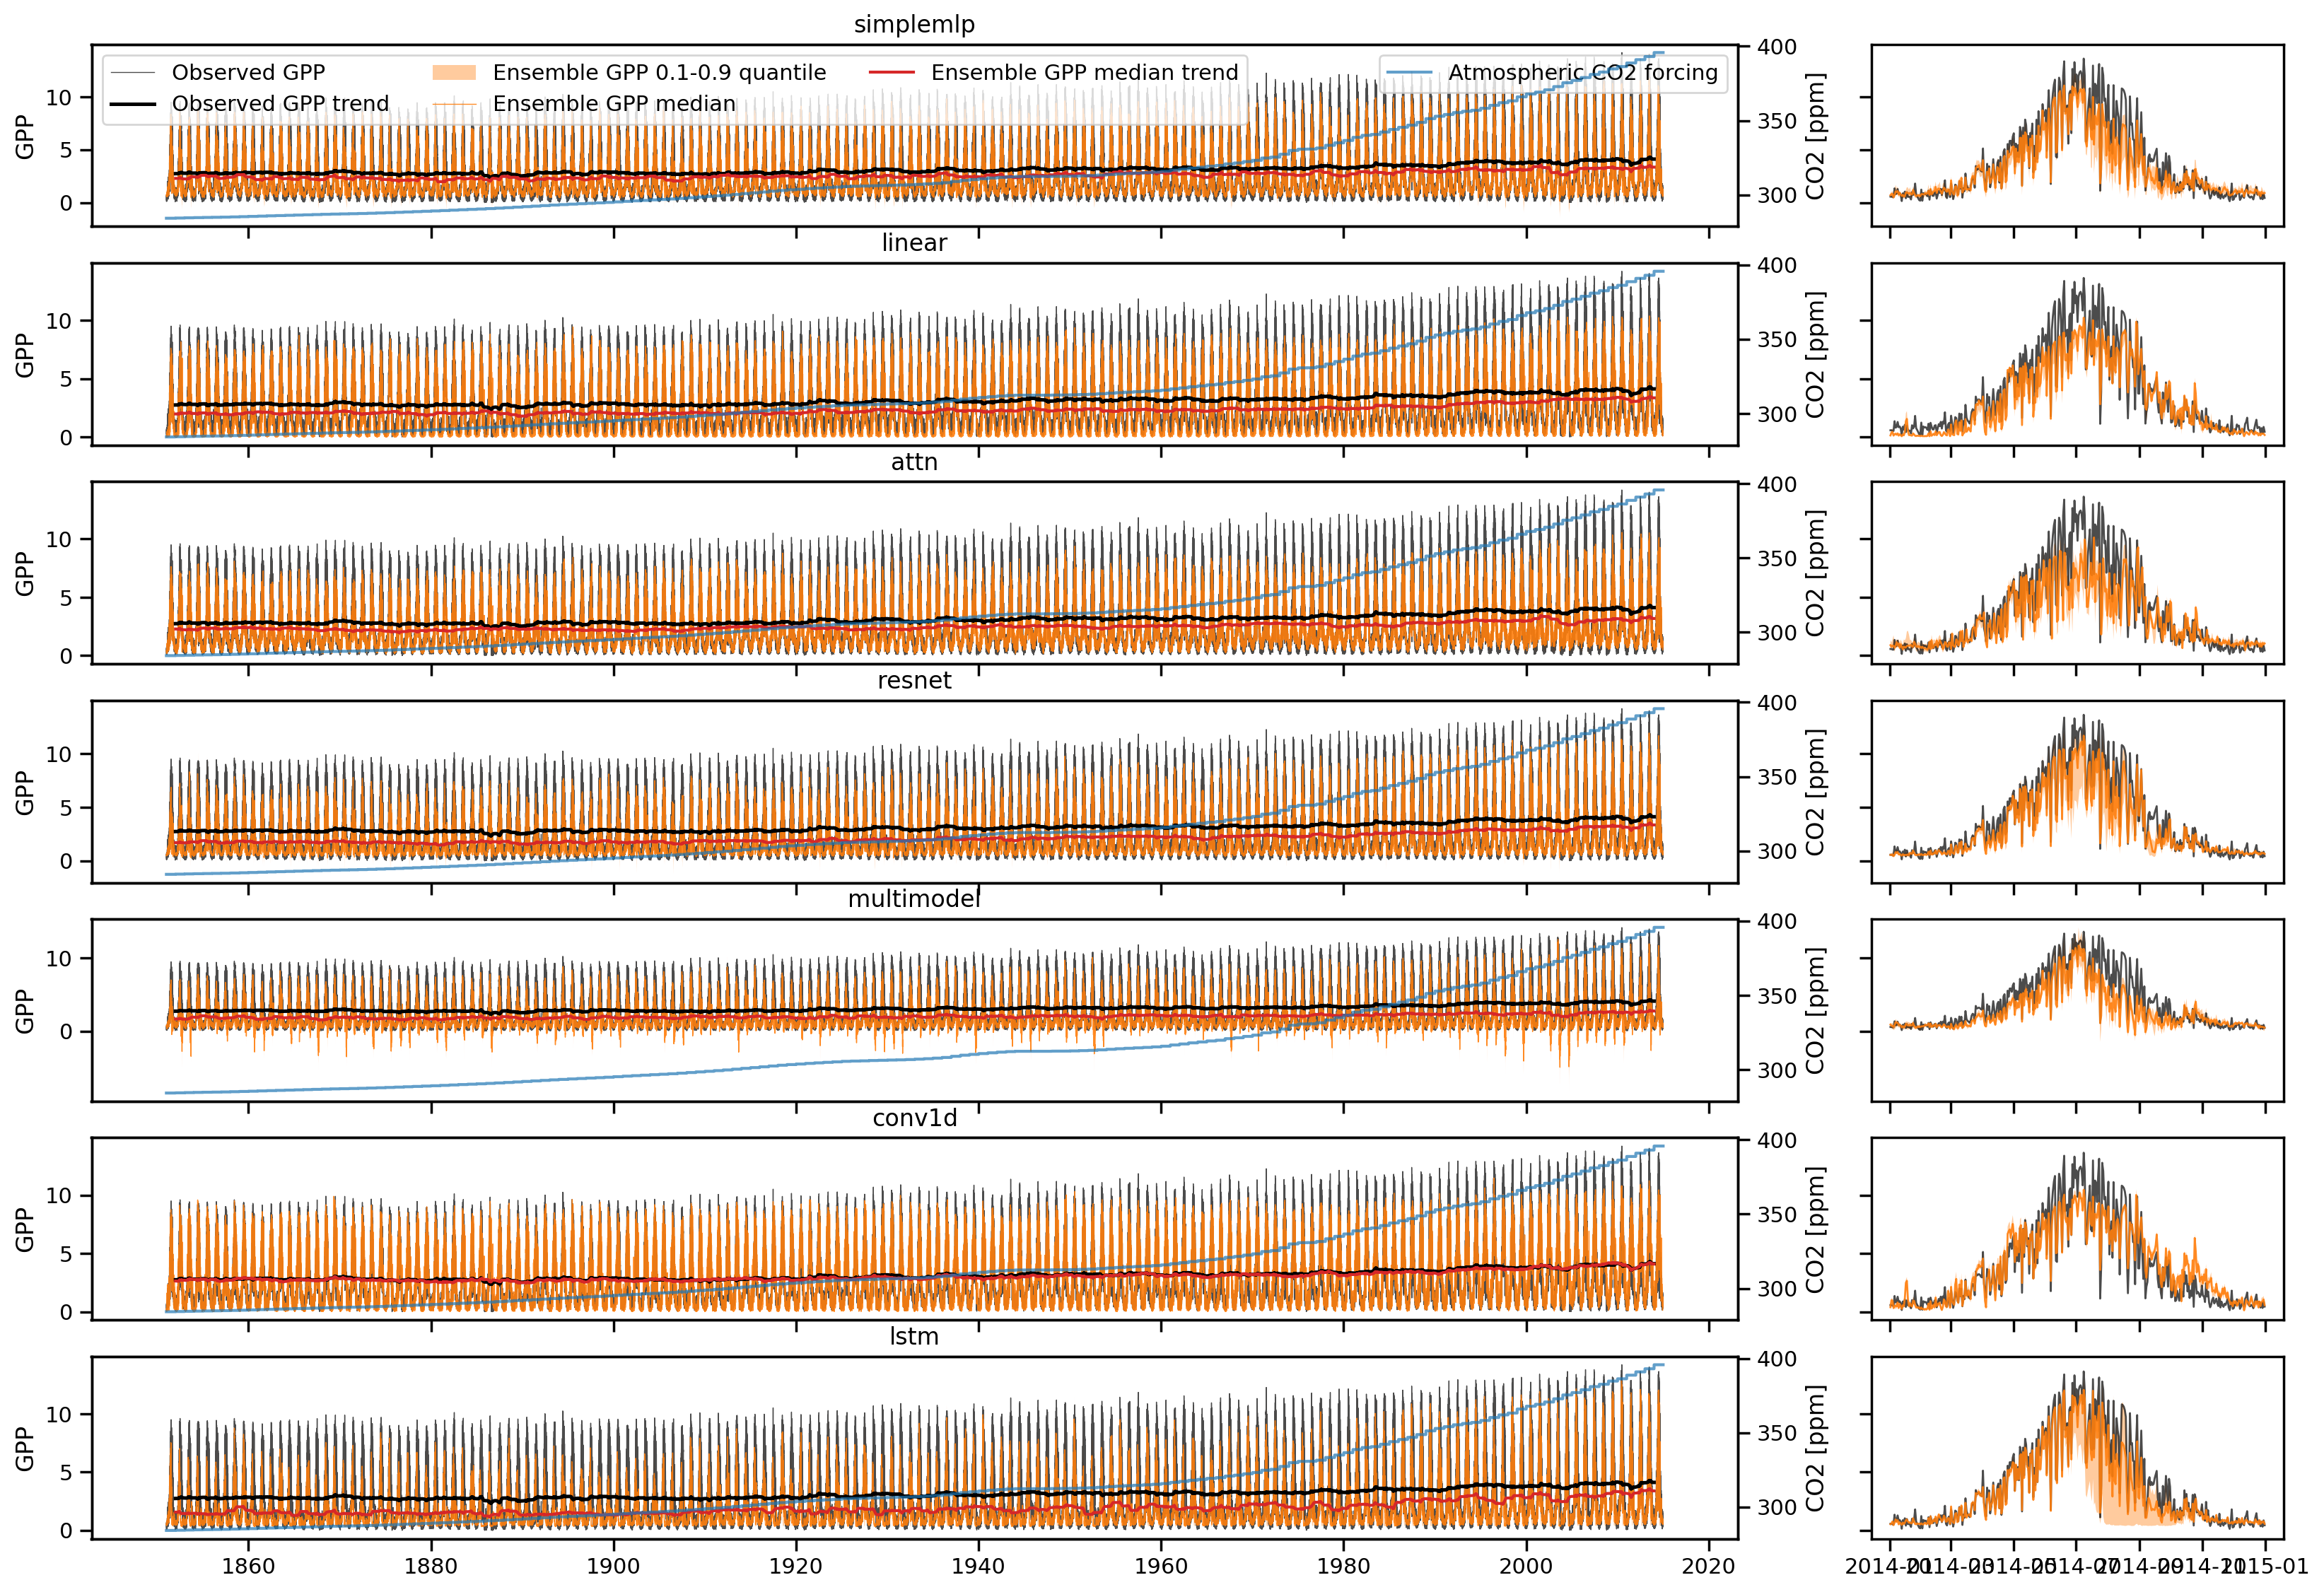

In [ ]:
plot_multimodel_ts(ds_space)

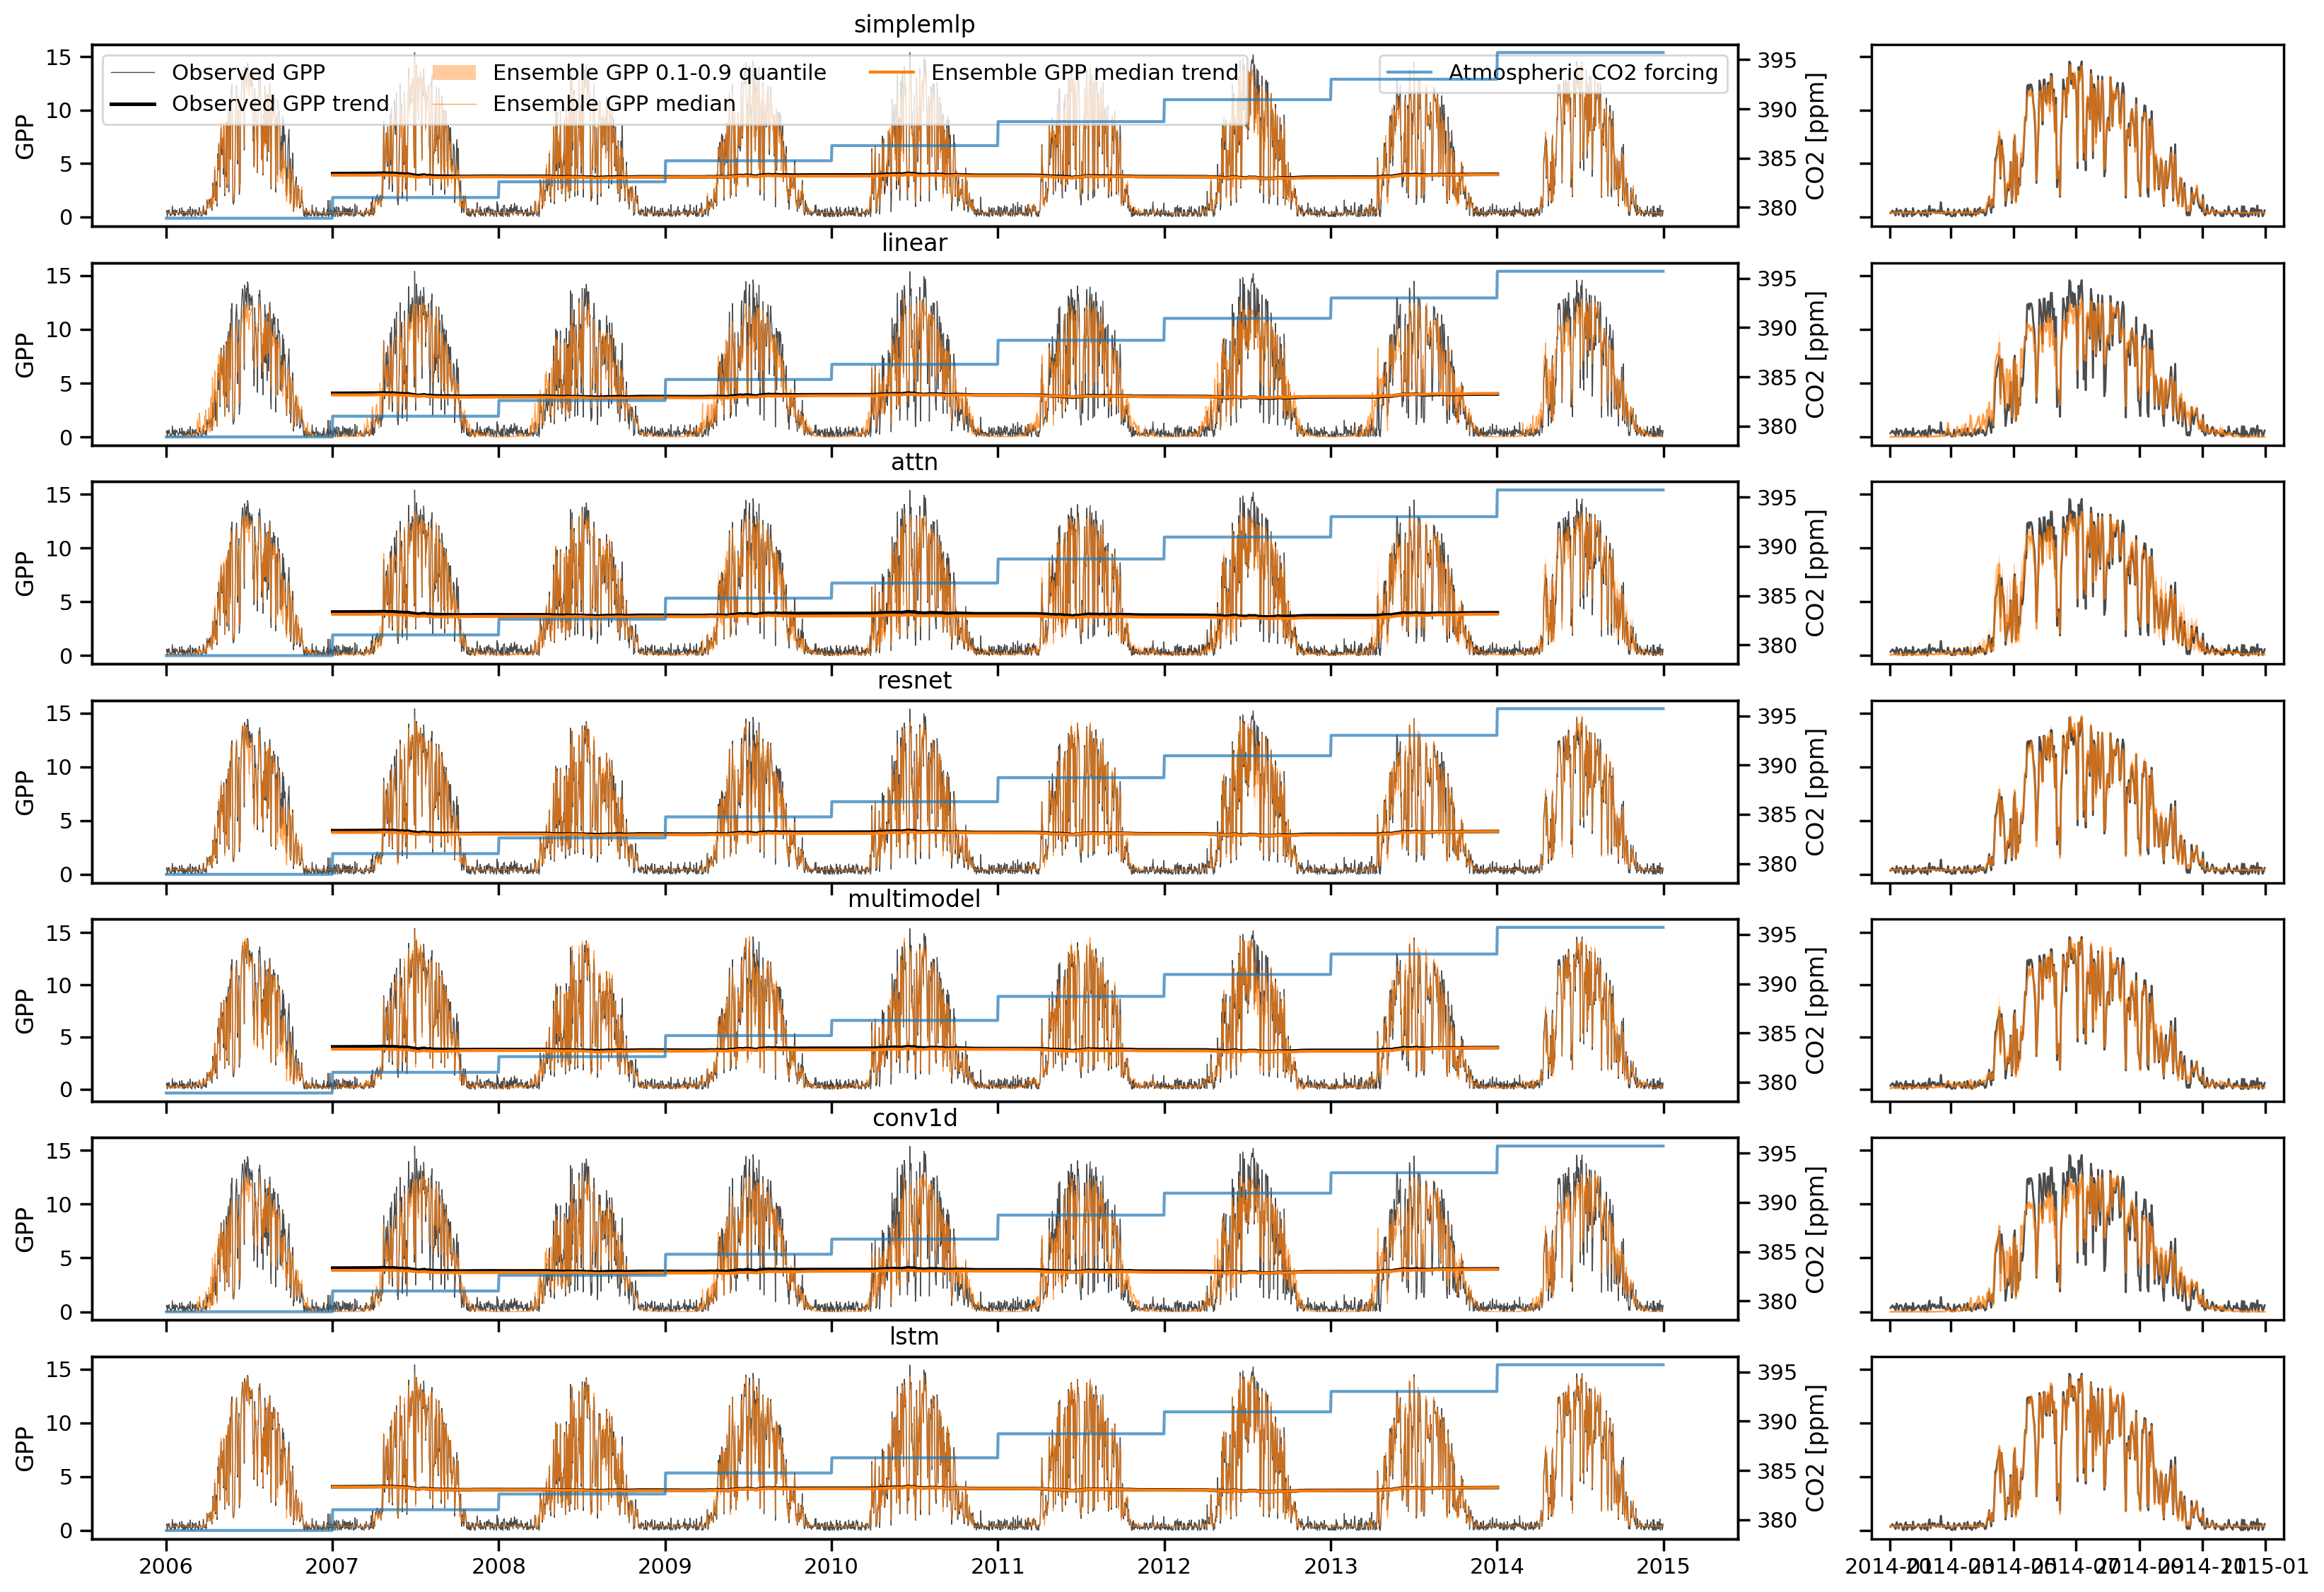

In [ ]:
plot_multimodel_ts(ds_val)

In [ ]:
met_space_global_df = met_space_global.sel(quantile=0.5).to_dataframe().reset_index()
met_time_global_df = met_time_global.sel(quantile=0.5).to_dataframe().reset_index()
met_val_global_df = met_val_global.sel(quantile=0.5).to_dataframe().reset_index()

met_space_global_df['mode'] = 'space'
met_time_global_df['mode'] = 'time'
met_val_global_df['mode'] = 'val'

met_global_df = pd.concat((met_space_global_df, met_time_global_df, met_val_global_df)).drop('quantile', axis=1)
met_global_df = pd.melt(met_global_df, id_vars=['model', 'mode'], value_vars=[f'nse', f'nse_msc', f'nse_iav'], var_name='scale')

In [ ]:
met_space_df = met_space.sel(quantile=0.5).to_dataframe().reset_index()
met_time_df = met_time.sel(quantile=0.5).to_dataframe().reset_index()
met_val_df = met_val.sel(quantile=0.5).to_dataframe().reset_index()

met_space_df['mode'] = 'space'
met_time_df['mode'] = 'time'
met_val_df['mode'] = 'val'

met_df = pd.concat((met_space_df, met_time_df, met_val_df)).drop('quantile', axis=1)
met_df = pd.melt(met_df, id_vars=['model', 'mode', 'location'], value_vars=[f'nse', f'nse_msc', f'nse_iav'], var_name='scale')

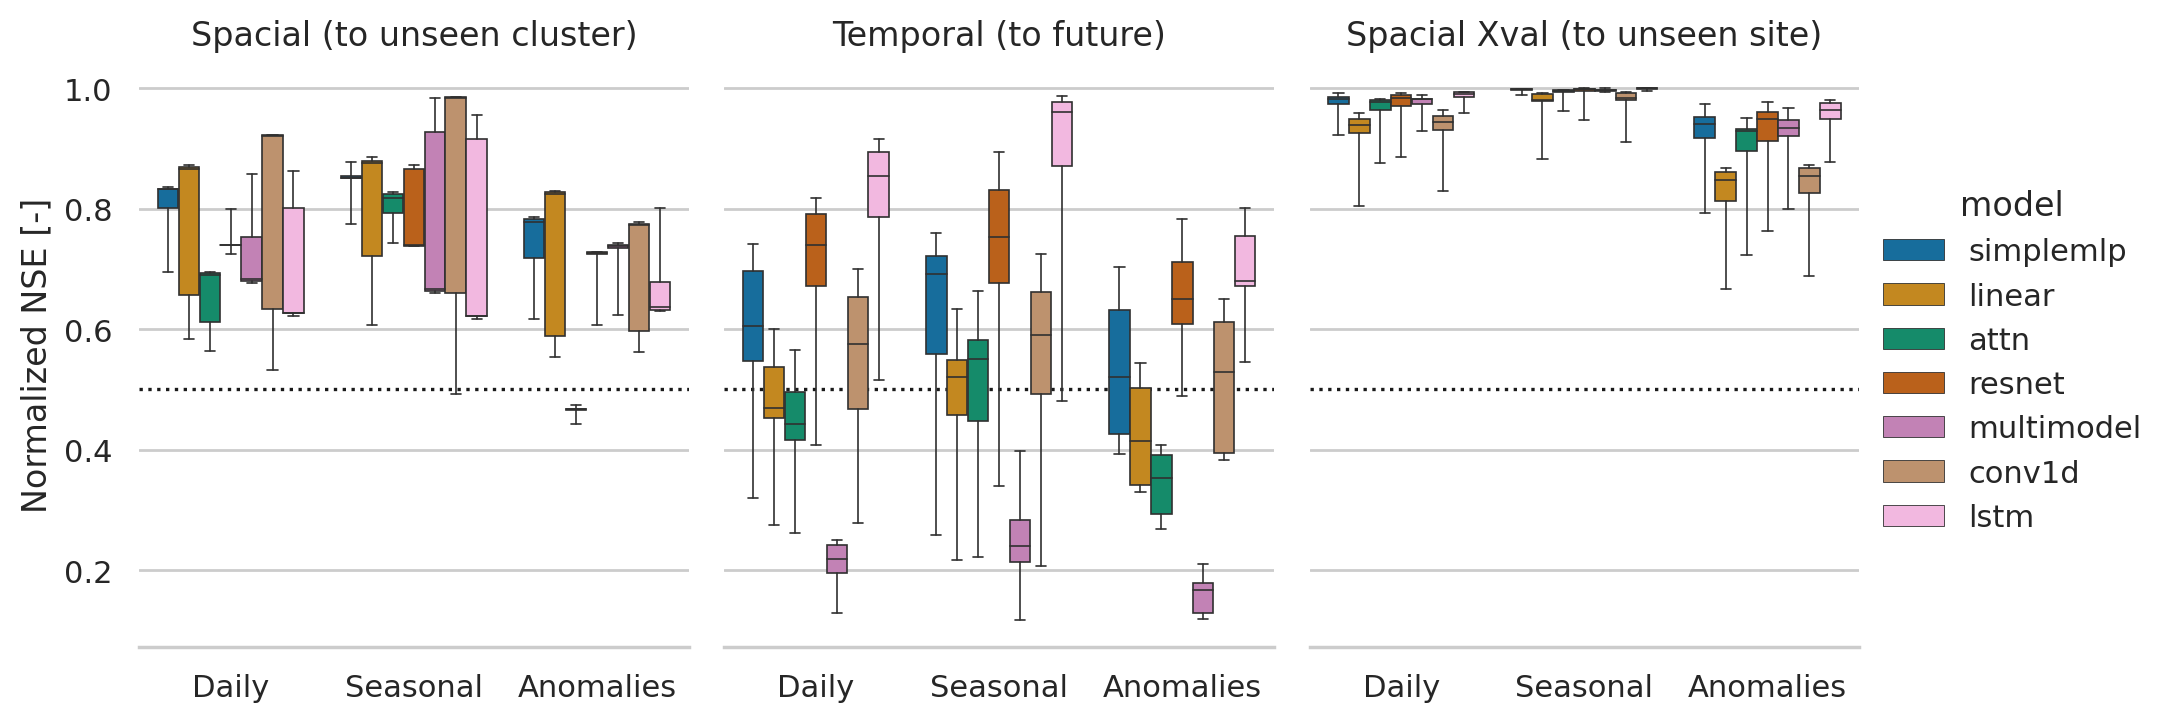

In [ ]:


g = sb.catplot(
    x='scale', 
    y='value',
    hue='model',
    col='mode',
    kind='box',
    data=met_df,
    palette='colorblind',
    height=4,
    aspect=0.8,
    whis=100000)

g.set_axis_labels('', 'Normalized NSE [-]')
g.set_xticklabels(['Daily', 'Seasonal', 'Anomalies'])
#g.set_titles(['1', '2', '3'])
g.despine(left=True)

for i, ax in enumerate(g.axes.flat):
    titles = [
        'Spacial (to unseen cluster)',
        'Temporal (to future)',
        'Spacial Xval (to unseen site)'
    ]
    ax.set_title(titles[i])
    ax.axhline(0.5, color='k', ls=':', lw=1.2, zorder=-1)

In [ ]:
met_global_rmse = met_val_global_df.set_index('model')[['rmse']].rename(columns={'rmse': 'xval'})
met_global_rmse['space'] = met_space_global_df.set_index('model')['rmse']
met_global_rmse['time'] = met_time_global_df.set_index('model')['rmse']
met_global_rmse.columns = [
    'Spacial Xval (to unseen site)',
    'Spacial (to unseen cluster)',
    'Temporal (to future)',
]

mn, mx = met_global_rmse.stack().quantile([0.1, 0.9])
def make_pretty(styler: pd.io.formats.style.Styler):
    styler.set_caption('Model extrapolation skill (RMSE)')
    styler.format(precision=2)
    styler.background_gradient(axis=None, vmin=mn, vmax=mx, cmap='PiYG_r')
    return styler

met_global_rmse.T.style.pipe(make_pretty)

In [ ]:
met_space_df= met_space.to_dataframe().reset_index()
met_time_df= met_time.to_dataframe().reset_index()

In [ ]:
met_space_df

location  quantile       model  cluster       nse   nse_msc   nse_iav  \
0          11       0.1   simplemlp        3  0.665088  0.638485  0.734919   
1          11       0.1      linear        3  0.757534  0.748553  0.765921   
2          11       0.1        attn        3  0.564934  0.603072  0.462126   
3          11       0.1      resnet        3  0.550034  0.519252  0.635184   
4          11       0.1  multimodel        3  0.564093  0.525966  0.700262   
..        ...       ...         ...      ...       ...       ...       ...   
100        15       0.9        attn        3  0.739651  0.949963  0.444626   
101        15       0.9      resnet        3  0.911622  0.944351  0.825165   
102        15       0.9  multimodel        3  0.767277  0.780375  0.747198   
103        15       0.9      conv1d        3  0.909561  0.977108  0.755274   
104        15       0.9        lstm        3  0.821124  0.868688  0.706027   

         rmse  rmse_msc  rmse_iav  
0    2.066836  1.842496  0.873332  
1    1.647798  1.419158  0.803893  
2    2.555987  1.986509  1.568806  
3    2.634359  2.356071  1.102037  
4    2.560362  2.324581  0.951372  
..        ...       ...       ...  
100  1.738533  0.565747  1.635508  
101  0.912395  0.598402  0.673600  
102  1.613847  1.307733  0.851196  
103  0.924016  0.377314  0.833000  
104  1.367698  0.958407  0.944279  

[105 rows x 10 columns]

In [ ]:
def sel(df, **sel):
    for k, v in sel.items():
        if (not isinstance(v, str)) and hasattr(v, '__iter__'):
            df = df.loc[df[k].isin(v), :]
        else:
            df = df.loc[df[k] == v, :]
    return df

In [ ]:
def df_diff(x, y):
    x = x.reset_index()
    y = y.reset_index()
    for m in ['nse', 'nse_msc', 'nse_iav', 'rmse', 'rmse_msc', 'rmse_iav']:
        x[m] = x[m] - y[m]
    return x

In [ ]:
df_diff(sel(d, quantile=0.5), sel(d, quantile=0.1))

index  location  quantile   model  cluster       nse   nse_msc   nse_iav  \
0      6        11       0.5  conv1d        3  0.011663  0.028754 -0.019714   
1     24        12       0.5  conv1d        3 -0.028535 -0.050656 -0.004010   
2     42        13       0.5  conv1d        3 -0.032933 -0.061346 -0.009037   
3     60        14       0.5  conv1d        3  0.010158  0.026593 -0.019879   
4     78        15       0.5  conv1d        3  0.011678  0.028619 -0.019502   

       rmse  rmse_msc  rmse_iav  
0 -0.067253 -0.224754  0.044498  
1  0.125784  0.161190  0.011849  
2  0.113291  0.144984  0.021792  
3 -0.058238 -0.212332  0.044410  
4 -0.067219 -0.218785  0.044260

In [ ]:
sel(d, quantile=0.1).reset_index()

index  location  quantile   model  cluster       nse   nse_msc   nse_iav  \
0      0        11       0.1  conv1d        3  0.911440  0.957018  0.797069   
1     18        12       0.1  conv1d        3  0.560333  0.543151  0.566016   
2     36        13       0.1  conv1d        3  0.666094  0.722180  0.605498   
3     54        14       0.1  conv1d        3  0.912315  0.959794  0.793737   
4     72        15       0.1  conv1d        3  0.909630  0.955488  0.794893   

       rmse  rmse_msc  rmse_iav  
0  0.907891  0.518922  0.733729  
1  2.122379  1.508403  1.447227  
2  1.509161  0.935073  1.145684  
3  0.897414  0.498420  0.734722  
4  0.923632  0.532054  0.743350

location  quantile   model  cluster       nse   nse_msc   nse_iav  \
6         11       0.5  conv1d        3  0.923103  0.985772  0.777355   
24        12       0.5  conv1d        3  0.531798  0.492496  0.562006   
42        13       0.5  conv1d        3  0.633161  0.660834  0.596462   
60        14       0.5  conv1d        3  0.922473  0.986387  0.773857   
78        15       0.5  conv1d        3  0.921307  0.984107  0.775391   

        rmse  rmse_msc  rmse_iav  
6   0.840638  0.294169  0.778227  
24  2.248163  1.669593  1.459077  
42  1.622451  1.080058  1.167476  
60  0.839176  0.286088  0.779133  
78  0.856413  0.313269  0.787610

<AxesSubplot:xlabel='model', ylabel='nse'>

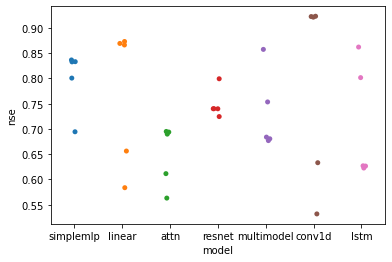

In [ ]:
sb.stripplot(x='model', y='nse', data=sel(met_space_df, quantile=0.5))

<AxesSubplot:xlabel='model', ylabel='rmse'>

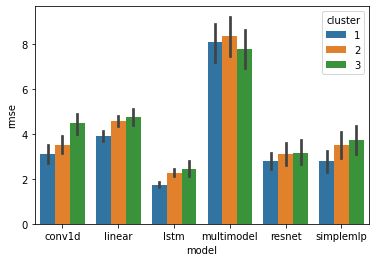

In [ ]:
sb.barplot(x='model', y='rmse', hue='cluster', data=met_time_df)

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

vars = [
    'vpd',
    'tmin',
    'tp',
    'ssrd',
    'sfcWind',
    'e',
    'FPAR',
    'co2'
]

def get_expl(model: str, explainer: str) -> xr.Dataset:
    exp_path = f'../logs/{model}/expl_2004/{explainer}/explanations.nc'
    ds = xr.open_dataset(exp_path)
    ds['var'] = vars
    return ds

def get_multi_expl(models: dict, explainer: str, **sel) -> xr.Dataset:
    expls = []
    for model in models.keys():
        expls.append(get_expl(model=model, explainer=explainer))

    expls = xr.concat(expls, dim='model')
    expls['model'] = list(models.keys())
    expls = expls.assign_coords(model_name=('model', list(models.values())))
    expls = expls.assign_coords(season=('time', expls['time'].dt.month.data.astype('float')))

    return expls.GPP_sens.sel(**sel)

In [4]:
models = dict(
    gt_model='Ground truth',
    linear='Linear',
    simplemlp='Lagged MLP',
    lstm='LSTM',
    attn_nores='Attn_nores',
)

exp_grad = get_multi_expl(models, explainer='gradexplainer', time='2007')
exp_gradx = get_multi_expl(models, explainer='inputxgradexplainer', time='2007')
exp_gradint = get_multi_expl(models, explainer='integratedgradientsexplainer', time='2007')


In [64]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

vars = [
    'vpd',
    'tmin',
    'tp',
    'ssrd',
    'sfcWind',
    'e',
    'FPAR',
    'co2'
]

def get_expl(model: str, explainer: str) -> xr.Dataset:
    exp_path = f'../logs/{model}/expl_2004/{explainer}/explanations.nc'
    ds = xr.open_dataset(exp_path)
    ds['var'] = vars
    
    if explainer == 'integratedgradientsexplainer' and model == 'gt_model':
        ds['GPP_sens'] = ds['GPP_sens'].where(ds['var'] != 'sfcWind', other=np.nan)
    
    return ds

def get_multi_expl(models: dict, explainer: str, **sel) -> xr.Dataset:
    expls = []
    for model in models.keys():
        expls.append(get_expl(model=model, explainer=explainer))

    expls = xr.concat(expls, dim='model')
    expls['model'] = list(models.keys())
    expls = expls.assign_coords(model_name=('model', list(models.values())))
    expls = expls.assign_coords(season=('time', expls['time'].dt.month.data.astype('float')))

    return expls.GPP_sens.sel(**sel)

models = dict(
    gt_model='Ground truth',
    linear='Linear',
    simplemlp='Lagged MLP',
    lstm='LSTM',
    attn_nores='Attention',
)

exp_grad = get_multi_expl(models, explainer='gradexplainer', time='2007')
exp_gradx = get_multi_expl(models, explainer='inputxgradexplainer', time='2007')
exp_gradint = get_multi_expl(models, explainer='integratedgradientsexplainer', time='2007')


In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

vars = [
    'vpd',
    'tmin',
    'tp',
    'ssrd',
    'sfcWind',
    'e',
    'FPAR',
    'co2'
]

def get_expl(model: str, explainer: str) -> xr.Dataset:
    exp_path = f'../logs/{model}/expl/{explainer}/explanations.nc'
    ds = xr.open_dataset(exp_path)
    ds['var'] = vars
    
    if explainer == 'integratedgradientsexplainer' and model == 'gt_model':
        ds['GPP_sens'] = ds['GPP_sens'].where(ds['var'] != 'sfcWind', other=np.nan)
    
    return ds

def get_multi_expl(models: dict, explainer: str, **sel) -> xr.Dataset:
    expls = []
    for model in models.keys():
        expls.append(get_expl(model=model, explainer=explainer))

    expls = xr.concat(expls, dim='model')
    expls['model'] = list(models.keys())
    expls = expls.assign_coords(model_name=('model', list(models.values())))
    expls = expls.assign_coords(season=('time', expls['time'].dt.month.data.astype('float')))

    return expls.GPP_sens.sel(**sel)

models = dict(
    gt_model='Ground truth',
    linear='Linear',
    simplemlp='Lagged MLP',
    lstm='LSTM',
    attn_nores='Attention',
)

exp_grad = get_multi_expl(models, explainer='gradexplainer', time='2014')
exp_gradx = get_multi_expl(models, explainer='inputxgradexplainer', time='2014')
exp_gradint = get_multi_expl(models, explainer='integratedgradientsexplainer', time='2014')


In [6]:

exp_path = f'../logs/gt_model/expl_2004/gradexplainer/explanations.nc'
ds = xr.open_dataset(exp_path)
ds

<xarray.Dataset>
Dimensions:      (var: 8, location: 10, context_lag: 30, time: 730)
Coordinates:
  * var          (var) object 'var1' 'var2' 'var3' ... 'var6' 'var7' 'co2'
  * location     (location) int64 1 2 3 4 5 6 7 8 9 10
  * context_lag  (context_lag) int64 29 28 27 26 25 24 23 22 ... 7 6 5 4 3 2 1 0
  * time         (time) datetime64[ns] 2006-01-01T12:00:00 ... 2007-12-31T12:...
Data variables:
    GPP_sens     (context_lag, time, location, var) float32 ...
Attributes:
    var_prob:  [0.99999523 0.99805921 0.9916538  0.99546939 1.         0.9916...
    co2_sens:  0.00019902482745237648

In [50]:
def plot_grads(exp: xr.DataArray, location: int = 0):
    fig, axes = plt.subplots(
        len(exp['model']), len(exp['var']), sharex=True, sharey=True, figsize=(10, len(exp['model']) * 1.3),
        gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    months = np.arange(1, 13)
    lag = np.log(exp.context_lag.values + 1)
    x, y = np.meshgrid(lag, months, indexing='ij')

    for var_i, var in enumerate(exp['var']):
        grads = exp.sel(var=var).mean('location').mean('model')
        grads_m = grads.groupby('time.month').mean().T
        lim = np.abs(grads_m).quantile(0.9)

        normalization = 1 / lim
        lim = 1
        
        for model_i, model in enumerate(exp['model']):
        
            ax = axes[model_i, var_i]
        
            # Check if the variable is 'sfcWind'
            if var == 'sfcWind':
                # Create a blank plot for the first sfcWind
                if model_i == 0:
                    ax.set_xticks([])  # Remove x-ticks
                    ax.set_yticks([])  # Remove y-ticks
                    ax.set_title('Wind')  # Set title for the first sfcWind
                    if var_i == 0:
                        ax.set_ylabel(grads_m.model_name.item())  # Set y-label if needed
                else:
                    # For subsequent sfcWind plots, plot the data
                    grads = exp.sel(model=model, var=var).mean('location')
                    grads_m = grads.groupby('time.month').mean().T
    
                    grads_m = grads_m * normalization
                    
                    pcm = ax.pcolormesh(x, y, grads_m.values.T, shading='auto', linewidth=0.002, edgecolor='w', cmap='coolwarm',
                        vmin=-lim, vmax=lim)
                    lag_idx = [0, 1, 2, 6, -1]
                    lag_label = [0, 1, 2, '...', 29]
                    ax.set_xticks(lag[-1::-1][lag_idx], lag_label)
                    ax.set_yticks(np.arange(1, 12.5, 3), ['Jan', 'Apr', 'Jul', 'Oct'])
    
                    if var_i == 0:
                        ax.set_ylabel(grads_m.model_name.item())
                continue  # Skip to the next variable
            
            # Select the gradients for the current model and variable
            grads = exp.sel(model=model, var=var).mean('location')
    
            # If the variable is 'e', multiply by -1
            if var == 'e':
                grads = grads * -1
    
            grads_m = grads.groupby('time.month').mean().T

            grads_m = grads_m * normalization
    
            #lim = np.abs(grads_m).quantile(1)
            pcm = ax.pcolormesh(x, y, grads_m.values.T, shading='auto', linewidth=0.002, edgecolor='w', cmap='coolwarm',
                vmin=-lim, vmax=1)
            lag_idx = [0, 1, 2, 6, -1]
            lag_label = [0, 1, 2, '...', 29]
            ax.set_xticks(lag[-1::-1][lag_idx], lag_label)
            ax.set_yticks(np.arange(1, 12.5, 3), ['Jan', 'Apr', 'Jul', 'Oct'])
    
            if var_i == 0:
                ax.set_ylabel(grads_m.model_name.item())
    
            # Set titles for other variables
            if model_i == 0:
                if var == 'tmin':
                    ax.set_title(r'T$_{min}$')  # Title for tmin
                elif var == 'vpd':
                    ax.set_title('VPD')  # Title for vpd
                elif var == 'e':
                    ax.set_title('E')  # Title for e
                elif var == 'ssrd':
                    ax.set_title(r'SW$_{in}$')
                elif var == 'tp':
                    ax.set_title('P')  # Title for tp
                elif var == 'FPAR':
                    ax.set_title('FAPAR')  # Title for FAPAR
                elif var == 'co2':
                    ax.set_title(r'CO$_{2}$')  # Title for CO2
    
    axes[-1, 3].set_xlabel('Lag (day)', x=1)
    
    fig.tight_layout()
    fig.patch.set_facecolor('w')
    fig.align_ylabels(axes[:, 0])
    
    # Add a color bar
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    fig.colorbar(pcm, cax=cbar_ax)

    # Optionally save the figure
    # fig.savefig('test.png', dpi=300, bbox_inches='tight', transparent=False)

A gradient of 1 for sfcWind is often referred to as a "neutral" or "no-effect" gradient, because it means that the model is not amplifying or dampening the effect of the input on the output. Instead, the model is simply passing the input through to the output without any modification.

In the context of your analysis, a gradient of 1 for sfcWind might suggest that the model is not learning any complex relationships between the input and output for this variable, and is instead simply relying on the raw input data to make predictions. 

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_38618/3439574319.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


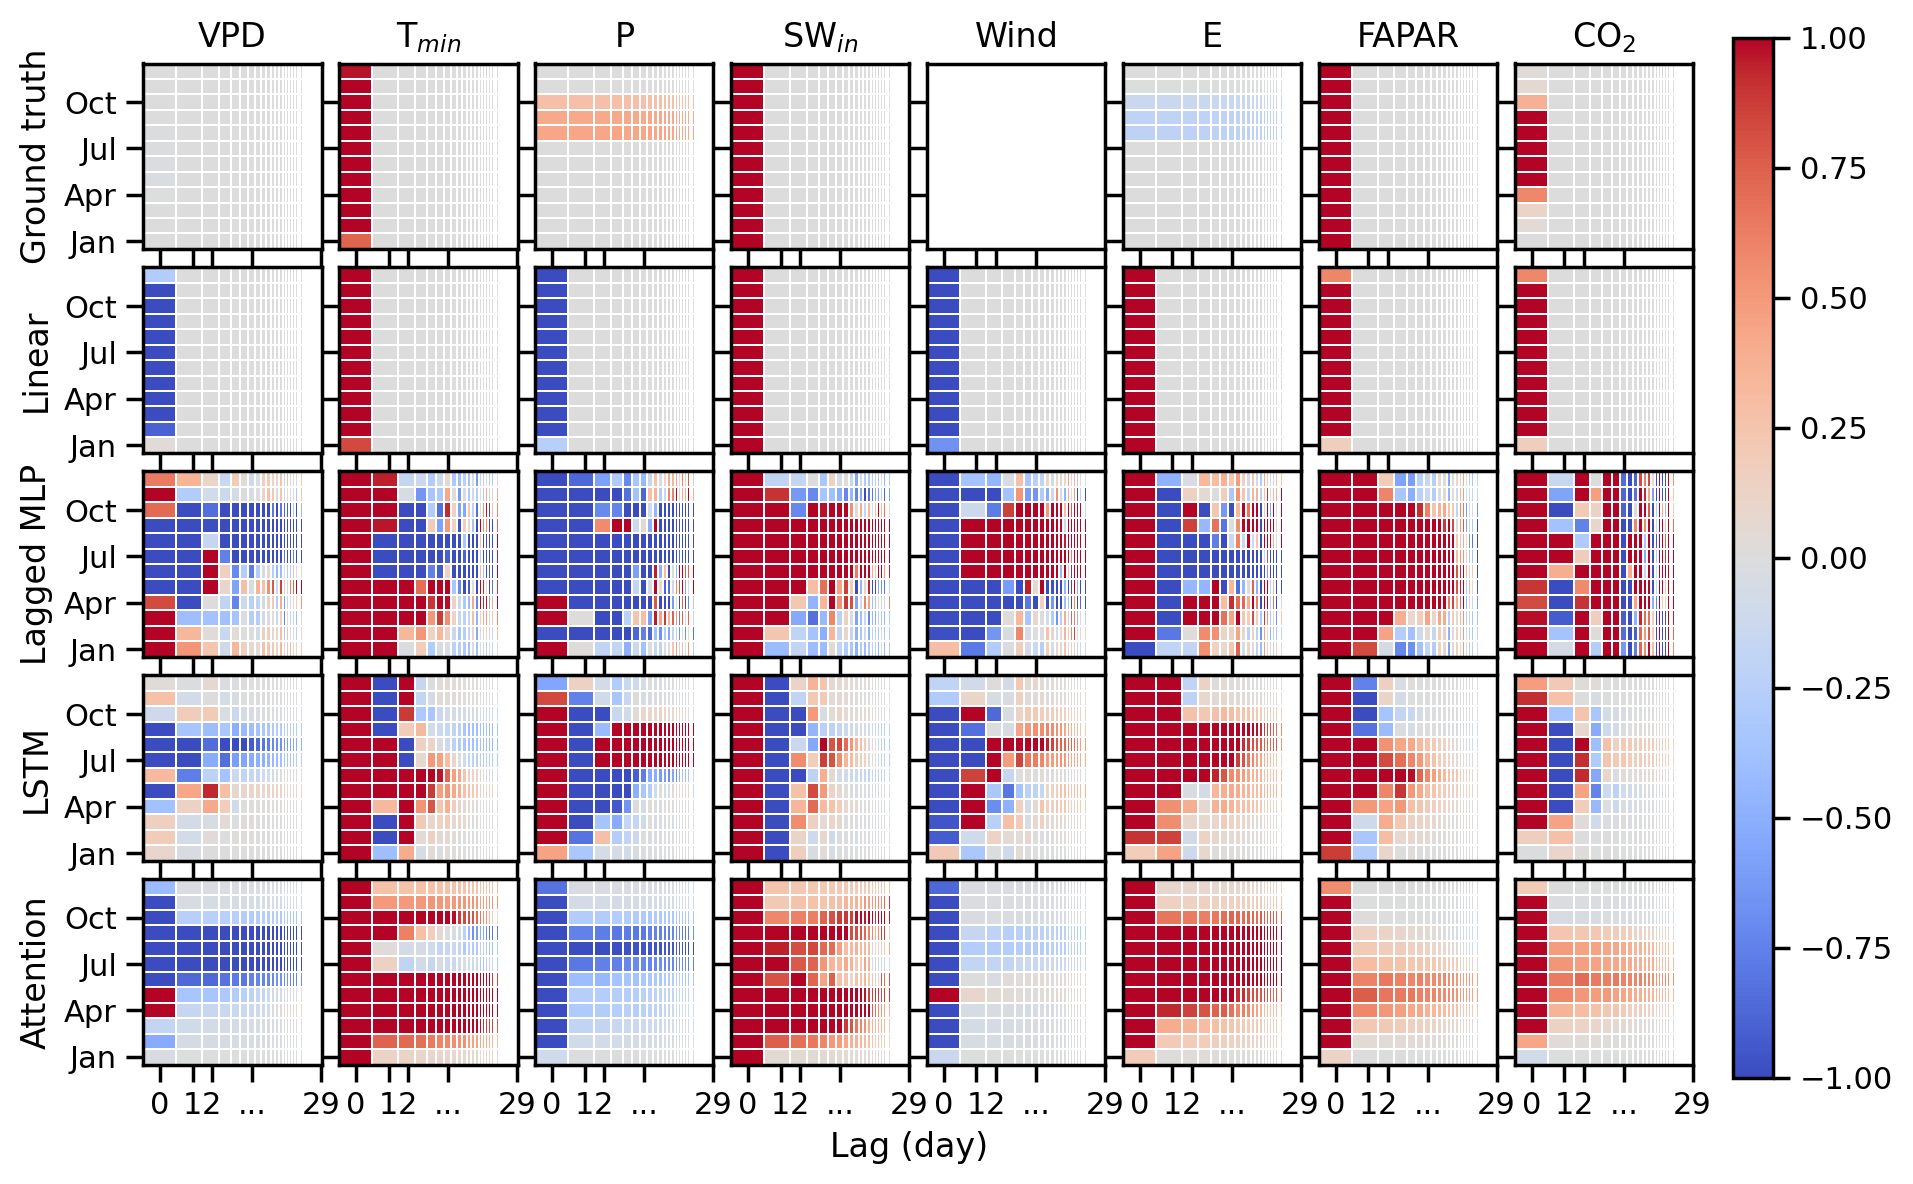

In [51]:
plot_grads(exp_grad)

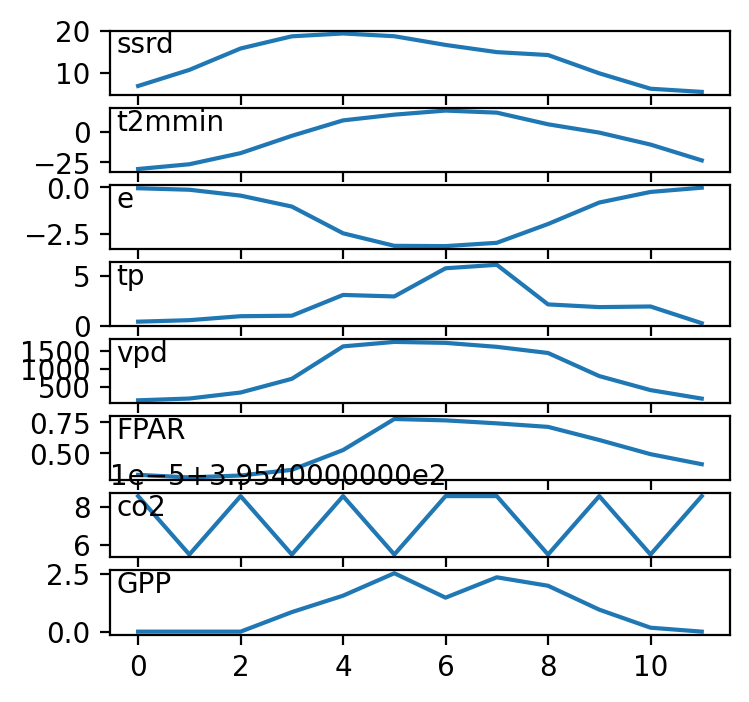

In [ ]:
ds = xr.open_dataset('../../simple_gpp_model/data/OBS/predictor-variables+GPP.nc').sel(time='2013').isel(location=0)

vars = [var for var in list(ds.data_vars) if var not in ['longitude', 'latitude']]

fig, axes = plt.subplots(len(vars), 1, figsize=(4, 4))

for i, var in enumerate(vars):
    ax = axes[i]
    ds_m = ds[var].groupby('time.month').mean()

    ax.plot(ds_m)

    ax.text(0.01, 0.99, var, va='top', ha='left', transform=ax.transAxes)


![img](https://pytorch.org/docs/stable/_images/Softplus.png)

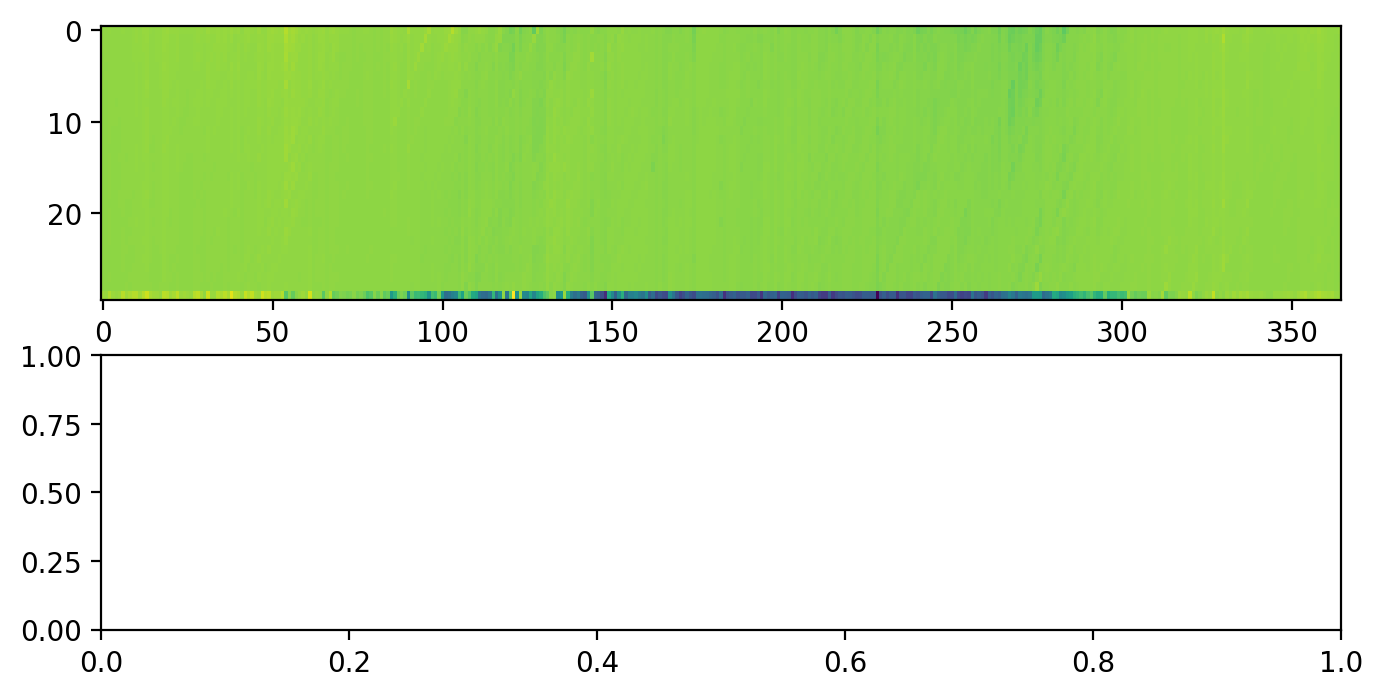

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].imshow(exp_grad.isel(location=1, var=0).sel(time='2014', model='attn'), aspect='auto')
# axes[1].imshow(exp_grad.isel(location=0).sel(time='2014', model='dummy2', context_lag=0).T, aspect='auto')

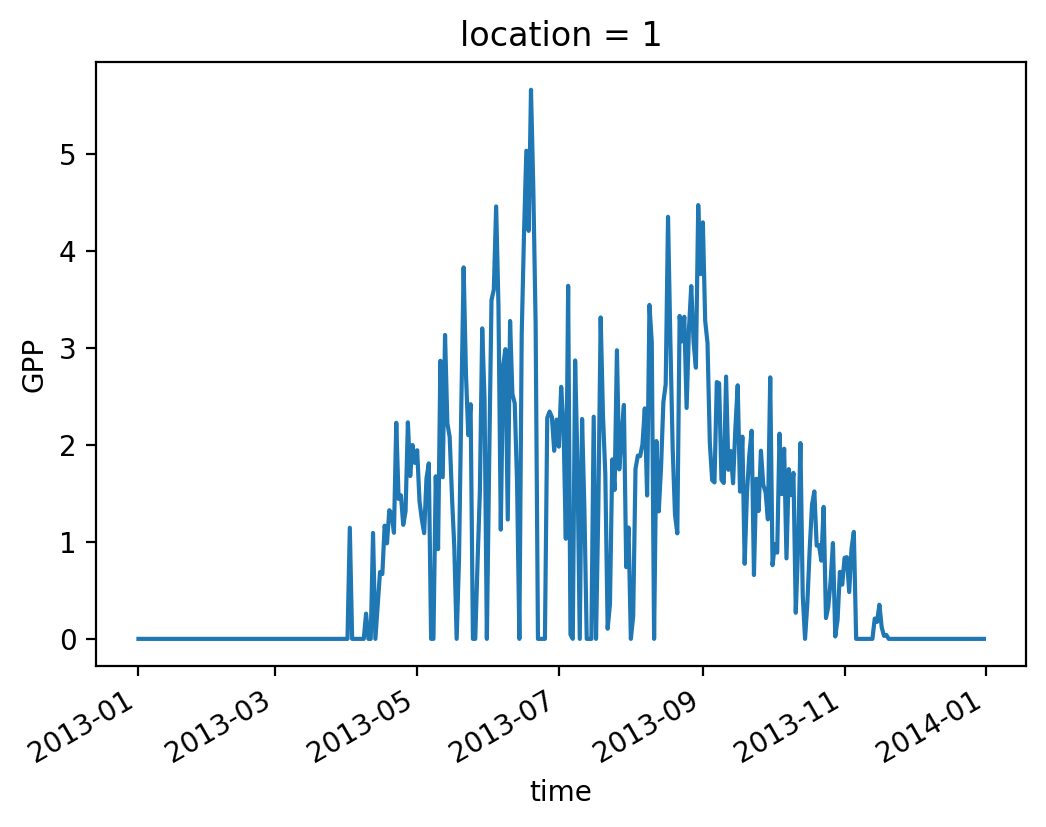

In [ ]:
ds.GPP.sel(time='2013').plot()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

vars = [
    'vpd',
    'tmin',
    'tp',
    'ssrd',
    'sfcWind',
    'e',
    'FPAR'
]

def get_ds(model: str) -> xr.Dataset:
    exp_path = f'../logs/{model}/sensitivity/CO2/predictions.nc'
    ds = xr.open_dataset(exp_path)
    ds = ds.rename({var: new_var for var, new_var in zip(ds.data_vars, vars)})
    return ds


In [ ]:
models = dict(
    # gt_model='Ground truth',
    # linear='Linear',
    # simplemlp='Lagged MLP',
    # lstm='LSTM',
    # attn='Attention',
    attn_nores='Attn_nores',
)

for model_name in models:
    ds = get_ds(model_name)



In [ ]:
ds

<xarray.Dataset>
Dimensions:   (time: 91676, location: 1, quantile: 3)
Coordinates:
  * location  (location) int64 1
  * time      (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T12:00:00
    cluster   (location) int64 ...
  * quantile  (quantile) float64 0.1 0.5 0.9
Data variables:
    vpd       (time, location) float32 ...
    tmin      (time, location) float32 ...
    tp        (time, location) float32 ...
    ssrd      (time, location) float32 ...
    sfcWind   (time, location) float32 ...
    e         (time, location) float32 ...
    FPAR      (time, location) float32 ...
    co2       (time, location) float32 ...
    GPP       (time, location) float32 ...
    GPP_hat   (quantile, time, location) float32 ...
    code      (time, location) float32 ...